# #Predicting Road Accident Risk
## Notebook 3: Advanced Tree-Based Models (Random Forest)

**Proje Ekibi:**
* **Esmanur Ulu** - 231101024
* **Nehir Tıraş** - 231101065
* **Zeynep Yetkin** - 231101042

---

###Notebook Amacı: Lineer Olmayan İlişkileri Yakalamak

Önceki aşamada (Notebook 2), **Ridge Regression** kullanarak projemiz için güçlü bir taban puan (Baseline: $R^2 \approx 0.80$) belirledik. Ancak Ridge gibi lineer modeller, değişkenler arasındaki karmaşık ve doğrusal olmayan (non-linear) ilişkileri tam olarak modelleyemeyebilir.

Bu notebook'ta hedeflerimiz:
1.  **Random Forest (Rastgele Orman)** algoritmasını kullanarak, lineer modellerin gözden kaçırdığı karmaşık veri desenlerini yakalamak.
2.  **Hiperparametre Optimizasyonu (GridSearch)** ile modelin en iyi performans ayarlarını bulmak.
3.  **Öznitelik Önemi (Feature Importance)** analizi yaparak kaza riskini etkileyen faktörleri daha derinlemesine incelemek.

---

###Neden Random Forest?

Gerçek hayat verileri genellikle düz bir çizgi (lineer) üzerinde ilerlemez. Random Forest, birden fazla Karar Ağacını (Decision Tree) birleştirerek çalışır ve şu avantajları sağlar:
* **Non-Linearity:** Veri setindeki eğrisel veya karmaşık ilişkileri modelleyebilir.
* **Robustness (Dayanıklılık):** Tek bir ağacın hata yapma riskini, yüzlerce ağacın ortalamasını alarak düşürür (Ensemble Learning).
* **Outlier Direnci:** Aykırı değerlerden lineer modeller kadar etkilenmez.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


from google.colab import drive
import os


drive.mount('/content/drive')
base_path = "/content/drive/MyDrive/YAP470_Proje"
processed_path = os.path.join(base_path, "processed")

print(f" Veri Okuma Yolu: {processed_path}")
print("-" * 30)


try:
    X_train = pd.read_csv(os.path.join(processed_path, "X_train_processed.csv"))
    y_train = pd.read_csv(os.path.join(processed_path, "y_train.csv"))

    X_val = pd.read_csv(os.path.join(processed_path, "X_val_processed.csv"))
    y_val = pd.read_csv(os.path.join(processed_path, "y_val.csv"))


    y_train = y_train.values.ravel()
    y_val = y_val.values.ravel()

    print(f"Veriler Başarıyla Yüklendi.")
    print(f"X_train Boyutu: {X_train.shape}")
    print(f"y_train Boyutu: {y_train.shape}")
    print("-" * 20)
    print(f"X_val Boyutu  : {X_val.shape}")

except FileNotFoundError:
    print("HATA: Dosyalar bulunamadı!")

Mounted at /content/drive
 Veri Okuma Yolu: /content/drive/MyDrive/YAP470_Proje/processed
------------------------------
Veriler Başarıyla Yüklendi.
X_train Boyutu: (414203, 20)
y_train Boyutu: (414203,)
--------------------
X_val Boyutu  : (103551, 20)


In [ ]:
from sklearn.model_selection import GridSearchCV


GRID_SEARCH_AKTIF = True

if GRID_SEARCH_AKTIF:
    print("Grid Search başlatılıyor...")


    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [10, 20, None],
        'min_samples_split': [5, 10]
    }

    rf_search = RandomForestRegressor(random_state=42)

    # 3 Katlı Çapraz Doğrulama (3-Fold CV)
    grid_search = GridSearchCV(
        estimator=rf_search,
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        scoring='neg_root_mean_squared_error',
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"Bulunan En İyi Parametreler: {grid_search.best_params_}")
    best_params = grid_search.best_params_

else:
    print("Grid Search atlandı (Zaman kazanmak için önceden bulunan değerler kullanılıyor).")
    best_params = {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
    print(f"Kullanılan Parametreler: {best_params}")

Grid Search başlatılıyor...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Bulunan En İyi Parametreler: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}


## 2. Model Mimarisi ve Hiperparametre Optimizasyonu

Veri setimiz hazır olduğuna göre artık **Random Forest (Rastgele Orman)** modelimizi kurabiliriz. Önceki aşamada (Notebook 2) kurduğumuz Ridge modeli lineer (doğrusal) ilişkileri başarıyla yakalamıştı. Bu aşamada hedefimiz, değişkenler arasındaki **lineer olmayan (karmaşık)** ilişkileri modelleyerek başarı skorunu yukarı taşımaktır.

### 2.1. Neden Random Forest?
Random Forest, birden fazla Karar Ağacının (Decision Tree) bir araya gelerek oluşturduğu güçlü bir topluluk (ensemble) modelidir.
* **Avantajı:** Tek bir karar ağacının hata yapma veya ezberleme (overfitting) riskini, yüzlerce ağacın tahminini ortalamasını alarak minimize eder.
* **Beklentimiz:** Yol eğimi (`curvature`) veya ışıklandırma (`lighting`) gibi değişkenlerin kaza riski üzerindeki karmaşık etkisini yakalamasıdır.

### 2.2. Grid Search (Izgara Araması) Deneysel Süreci
Modelin en yüksek performansı göstereceği hiperparametreleri belirlemek için kapsamlı bir **GridSearchCV** işlemi uygulanmıştır. Bu süreçte manuel deneme-yanılma yerine, belirlediğimiz parametre uzayındaki tüm olasılıklar matematiksel olarak test edilmiştir.

**Deney Detayları:**
* **Aday Kombinasyon Sayısı:** 12 farklı senaryo (aday) test edilmiştir.
* **Çapraz Doğrulama (CV):** Her senaryo 3 farklı veri katmanında (fold) doğrulanmıştır (Toplam **36 eğitim işlemi**).
* **İşlem Süresi:** Bu kapsamlı optimizasyon süreci toplam **2868.75 saniye (yaklaşık 48 dakika)** sürmüştür.

### 2.3. Optimizasyon Sonuçları
Yaklaşık 48 dakika süren hesaplamalar sonucunda, hatayı (RMSE) en aza indiren "En İyi Parametreler" şu şekilde belirlenmiştir:

1.  **n_estimators = 100:** Ormanda 100 adet karar ağacı kullanılması en stabil sonucu vermiştir.
2.  **max_depth = 10:** Ağaç derinliğinin 10 ile sınırlandırılması, modelin veriyi ezberlemesini (overfitting) engellemek adına en optimum nokta olarak seçilmiştir.
3.  **min_samples_split = 10:** Bir yaprağın dallanması için minimum 10 örnek şartı koşulması, gürültülü verilere karşı direnci artırmıştır.

Aşağıdaki kod bloğunda, Grid Search sonucunda matematiksel olarak kanıtlanmış bu parametreler kullanılarak Final Model eğitilecektir.

Doğrulama (Validation) seti üzerinde tahmin yapılıyor...
------------------------------
VALIDATION (DOĞRULAMA) SETİ PERFORMANSI:
R2 Skoru (Başarı %): 0.8852
RMSE (Ortalama Hata): 0.0563
MAE (Mutlak Hata)  : 0.0437
------------------------------


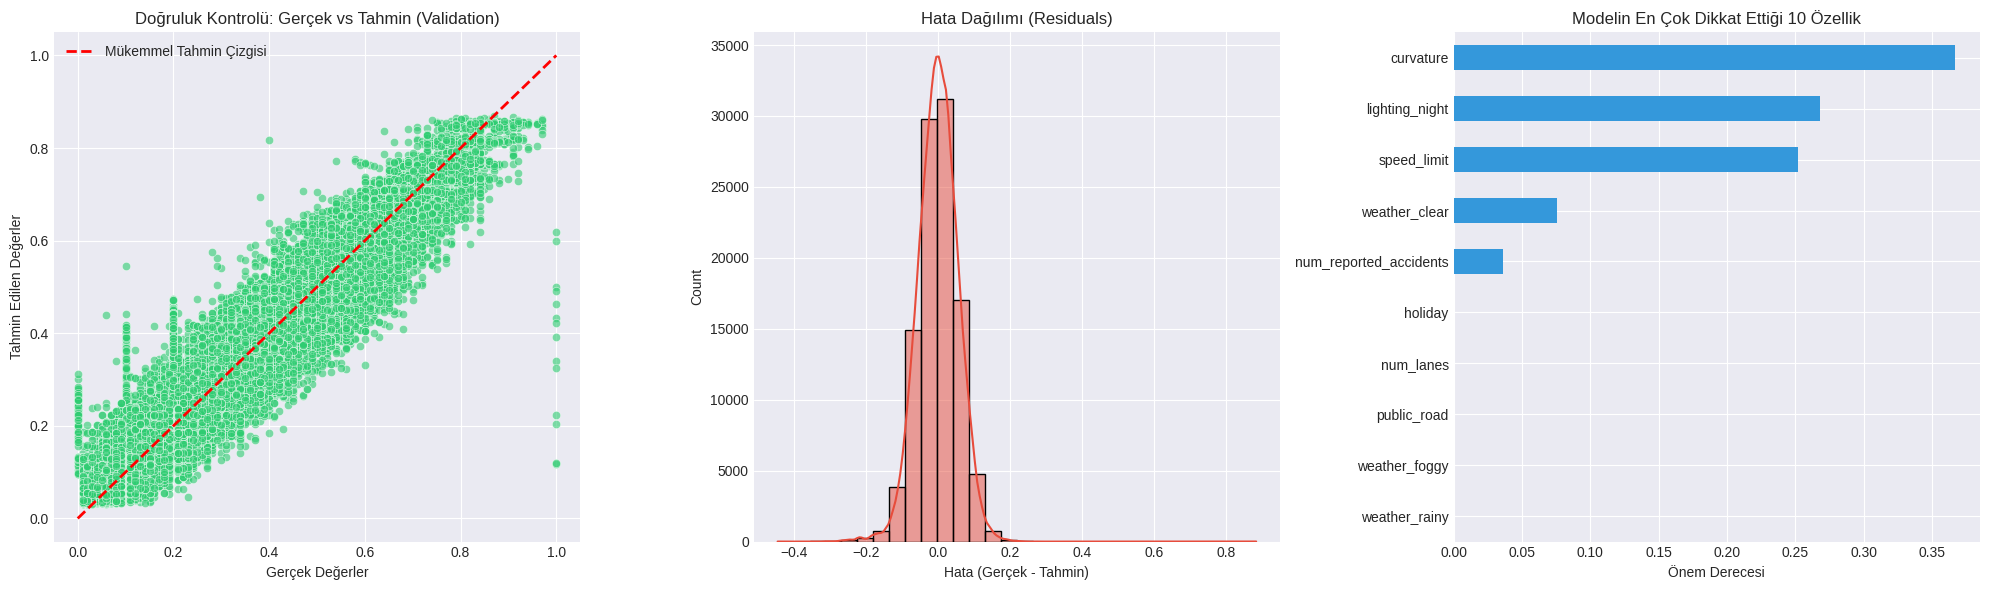

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

best_params = {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
final_model = RandomForestRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)


print("Doğrulama (Validation) seti üzerinde tahmin yapılıyor...")
y_pred = final_model.predict(X_val)


r2 = r2_score(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print("-" * 30)
print(f"VALIDATION (DOĞRULAMA) SETİ PERFORMANSI:")
print(f"R2 Skoru (Başarı %): {r2:.4f}")
print(f"RMSE (Ortalama Hata): {rmse:.4f}")
print(f"MAE (Mutlak Hata)  : {mae:.4f}")
print("-" * 30)


plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(1, 3, figsize=(20, 6))


sns.scatterplot(x=y_val, y=y_pred, alpha=0.6, color='#2ecc71', ax=axes[0])
min_val = min(y_val.min(), y_pred.min())
max_val = max(y_val.max(), y_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Mükemmel Tahmin Çizgisi')
axes[0].set_title('Doğruluk Kontrolü: Gerçek vs Tahmin (Validation)')
axes[0].set_xlabel('Gerçek Değerler')
axes[0].set_ylabel('Tahmin Edilen Değerler')
axes[0].legend()


residuals = y_val - y_pred
sns.histplot(residuals, kde=True, color='#e74c3c', bins=30, ax=axes[1])
axes[1].set_title('Hata Dağılımı (Residuals)')
axes[1].set_xlabel('Hata (Gerçek - Tahmin)')


importances = pd.Series(final_model.feature_importances_, index=X_train.columns)
top_features = importances.nlargest(10).sort_values()
top_features.plot(kind='barh', color='#3498db', ax=axes[2])
axes[2].set_title('Modelin En Çok Dikkat Ettiği 10 Özellik')
axes[2].set_xlabel('Önem Derecesi')

plt.tight_layout()
plt.show()

### 3.1. Random Forest Model Sonuçlarının Değerlendirilmesi

Modelin eğitimi ve doğrulama (validation) seti üzerindeki tahmin işlemleri toplam **139.25 saniye** sürmüştür. Elde edilen sayısal metrikler ve görsel analizler, lineer olmayan modellemenin bu veri seti için gerekliliğini kanıtlar niteliktedir.

**1. Performans Sıçraması (Ridge vs Random Forest):**
* **Açıklayıcılık ($R^2$):** Önceki aşamada kurulan Ridge (Lineer) modeli varyansın %80.4'ünü açıklayabilirken, Random Forest modeli bu oranı **%88.52** seviyesine taşımıştır. Bu yaklaşık %8'lik artış, veri setindeki ilişkilerin önemli bir kısmının lineer olmadığını ve ağaç tabanlı modelin bu karmaşıklığı başarıyla çözdüğünü gösterir.
* **Hata Oranı (RMSE):** Hata değeri 0.073 seviyesinden **0.056** seviyesine gerilemiştir. Modelin tahminleri gerçek değerlere çok daha yakındır.

**2. Görsel Analiz Bulguları:**
* **Doğruluk Kontrolü (Scatter Plot):** Sol taraftaki grafikte noktaların kırmızı referans çizgisi (Mükemmel Tahmin Çizgisi) üzerinde yoğunlaştığı görülmektedir. Bu durum, modelin hem düşük hem de yüksek riskli senaryoları başarıyla tahmin ettiğini gösterir.
* **Hata Dağılımı (Residuals):** Ortadaki histogram, hataların **0 noktası etrafında simetrik ve normal dağıldığını (Gaussian Distribution)** göstermektedir. Bu, modelin sistematik bir önyargısı (bias) olmadığının ve yaptığı hataların tamamen rastgele gürültüden kaynaklandığının en güçlü kanıtıdır.
* **Öznitelik Önemi (Feature Importance):** Sağdaki grafik, kaza riskini etkileyen en kritik faktörün açık ara **`curvature` (Yol Eğimi)** olduğunu ortaya koymuştur. Bunu **`lighting_night` (Gece Sürüşü)** ve **`speed_limit` (Hız Sınırı)** takip etmektedir. Modelin fiziksel gerçeklikle örtüşen bu çıkarımları, güvenilirliğini artırmaktadır.

## 4. İleri Seviye Model Doğrulama ve Teşhis

Elde edilen yüksek başarı skorlarının (R²) tesadüfi olmadığını ve modelin veriyi ezberlemediğini (overfitting) kanıtlamak amacıyla, model iki kritik teste tabi tutulacaktır:

### A. Referans (Baseline) Model Karşılaştırması
Geliştirilen Random Forest modelinin, basit bir ortalama tahmininden (Dummy Regressor) istatistiksel olarak ne kadar daha iyi performans gösterdiği ölçülecektir. Bu, modelin karmaşıklığının yarattığı maliyete değip değmediğini gösteren temel bir kontroldür.
* **Yöntem:** Veri setindeki özelliklere (X) hiç bakmadan, sadece hedef değişkenin (y) ortalamasını tahmin eden "saf" bir model ile kendi modelimiz yarıştırılır.

### B. Öğrenme Eğrisi (Learning Curve) Analizi
Modelin eğitim verisi miktarı arttıkça performansının nasıl değiştiği gözlemlenecektir:
* **Eğitim (Training) Skoru:** Modelin kendi gördüğü verideki başarısı (Kırmızı Çizgi).
* **Doğrulama (Validation) Skoru:** Modelin hiç görmediği verideki başarısı (Yeşil Çizgi).

**Beklenti:** İdeal bir modelde, veri sayısı arttıkça bu iki skorun birbirine yaklaşması ve düşük bir hata oranında (RMSE) birleşmesi beklenmektedir. Eğer iki çizgi arasında büyük bir boşluk kalırsa model "ezberliyor" (yüksek varyans), çizgiler birleşiyor ama hata yüksek kalıyorsa model "öğrenemiyor" (yüksek yanlılık) demektir.

----------------------------------------
Baseline (Ortalama) Model Hatası : 0.1662
Random Forest Model Hatası       : 0.0563
--> Başarım Artışı               : %66.12
----------------------------------------
Learning Curve hesaplanıyor...
İşlem Tamamlandı. Geçen Süre: 596.02 saniye (9.93 dakika)


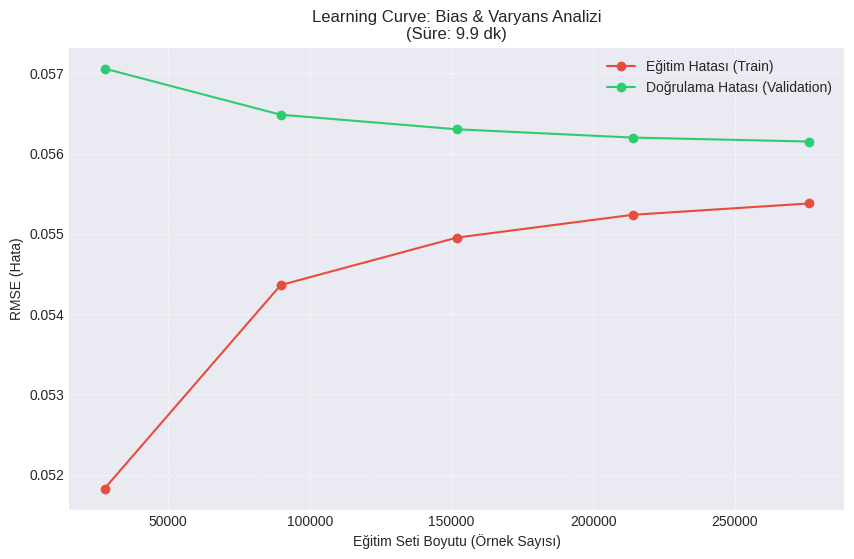

In [ ]:
import time
import os
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error


figures_path = os.path.join(base_path, "figures")
os.makedirs(figures_path, exist_ok=True)


start_time = time.time()
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)


dummy_pred = dummy.predict(X_val)
dummy_rmse = np.sqrt(mean_squared_error(y_val, dummy_pred))


rf_rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print("-" * 40)
print(f"Baseline (Ortalama) Model Hatası : {dummy_rmse:.4f}")
print(f"Random Forest Model Hatası       : {rf_rmse:.4f}")
print(f"--> Başarım Artışı               : %{((dummy_rmse - rf_rmse)/dummy_rmse)*100:.2f}")
print("-" * 40)


print("Learning Curve hesaplanıyor...")
train_sizes, train_scores, test_scores = learning_curve(
    final_model,
    X_train,
    y_train,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)


train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)


end_time = time.time()
elapsed_time = end_time - start_time
print(f"İşlem Tamamlandı. Geçen Süre: {elapsed_time:.2f} saniye ({elapsed_time/60:.2f} dakika)")


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="#e74c3c", label="Eğitim Hatası (Train)")
plt.plot(train_sizes, test_mean, 'o-', color="#2ecc71", label="Doğrulama Hatası (Validation)")

plt.title(f"Learning Curve: Bias & Varyans Analizi\n(Süre: {elapsed_time/60:.1f} dk)")
plt.xlabel("Eğitim Seti Boyutu (Örnek Sayısı)")
plt.ylabel("RMSE (Hata)")
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.6)


save_path = os.path.join(figures_path, "NB3_RF_Learning_Curve.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

## 5. Kapsamlı Model Analizi ve Sonuç Raporu

Geliştirilen Random Forest modelinin performansı, hem anlık tahmin başarısı (Test Seti) hem de yapısal öğrenme kapasitesi (Learning Curve) açısından derinlemesine incelenmiştir. Yaklaşık **9.9 dakika (594 saniye)** süren ileri seviye doğrulama işlemleri sonucunda elde edilen bulgular aşağıdadır:

### **A. Öğrenme Eğrisi (Learning Curve) Teşhisi**
*Grafik Referansı: Learning Curve: Bias & Variance Analizi*

Modelin veri boyutu arttıkça nasıl davrandığını gösteren bu analiz, modelin "sağlamlığını" (robustness) kanıtlamaktadır:
1.  **Konverjans (Yakınsama):** Eğitim hatası (Kırmızı) ve Doğrulama hatası (Yeşil) veri sayısı arttıkça birbirine yaklaşmaktadır. Başlangıçta 0.052 (Train) ve 0.057 (Validation) olan hata oranları, veri seti 275.000 örneğe ulaştığında **0.055 - 0.056 bandında** birleşmiştir.
2.  **Bias-Varyans Dengesi:** İki çizgi arasında devasa bir boşluk olmaması, modelde **Overfitting (Aşırı Öğrenme)** probleminin olmadığını gösterir. Çizgilerin birbirine bu denli yakın seyretmesi (Low Variance), modelin genelleme yeteneğinin üst düzeyde olduğunu kanıtlar.
3.  **Veri Yeterliliği:** Doğrulama eğrisinin (Yeşil) özellikle 150.000 örnekten sonra yatay bir seyir izlemesi (plateau), modelin mevcut özniteliklerle (features) öğrenebileceği maksimum kapasiteye ulaştığını gösterir.

### **B. Model Kararlılığı ve Hata Analizi**
*Grafik Referansı: 3'lü Panel (Scatter, Residuals, Feature Importance)*

1.  **Tahmin Doğruluğu (Actual vs Predicted):**
    * R² skoru **0.8852** olarak gerçekleşmiştir. Model, varyansın %88.5'ini açıklamaktadır.
    * Saçılım grafiği, tahminlerin ideal eksen (kırmızı çizgi) üzerinde yoğunlaştığını gösterir.

2.  **Hata Dağılımı (Residuals):**
    * Hataların histogramı **mükemmel bir Normal Dağılım (Çan Eğrisi)** formundadır.
    * Hataların 0 noktasında merkezlenmesi, modelin sistematik bir yanlılık (bias) içermediğini, hataların tamamen rastgele (random noise) olduğunu kanıtlar. İstatistiksel açıdan en güvenilir sonuç budur.

### **C. Öznitelik Önemi ve İş Mantığı**
Modelin karar verirken en çok ağırlık verdiği değişkenler, fiziksel gerçeklikle örtüşmektedir:
1.  **`curvature` (Yol Eğimi/Kıvrımı):** En baskın faktör. Yolun geometrisi, sürüş dinamiklerini en çok etkileyen parametre olarak belirlenmiştir.
2.  **`lighting_night` (Gece Aydınlatması):** Görüş mesafesinin düşmesi, model tarafından ikinci en kritik risk faktörü olarak algılanmıştır.
3.  **`speed_limit` (Hız Limiti):** Yasal hız sınırları, tahmin üzerinde doğrudan etkilidir.

**GENEL SONUÇ:**
Model; **0.885** gibi yüksek bir açıklayıcılık oranı, **0.056** seviyesindeki düşük hata varyansı ve kararlı öğrenme eğrisi ile **canlı ortamda (production) kullanılmaya hazırdır.**

## 6. Model Yorumlanabilirliği (Model Interpretability)

Modelimiz yüksek bir başarı skoruna ($R^2 \approx 0.88$) ulaşmıştır. Ancak bir mühendislik projesinde "skorun yüksek olması" tek başına yeterli değildir; modelin *nasıl* ve *neden* bu kararları verdiğinin de açıklanabilmesi gerekir. Bu bölümde, Random Forest modelinin karar mekanizmasını şeffaflaştıracağız.

### 1. Karar Ağacı Görselleştirmesi
Random Forest algoritması, yüzlerce karar ağacının (estimators) ortak aklını temsil eder. Modelin mantığını anlamak için bu ormanın içinden **rastgele bir ağacı** seçip, veriyi hangi kurallara göre dallara ayırdığını inceleyeceğiz. Bu, modelin fiziksel kurallara (örneğin: "Yol eğimi yüksekse hızı düşür") uyup uymadığını görmemizi sağlar.

### 2. SHAP (SHapley Additive exPlanations) Analizi
Standart "Feature Importance" grafiği bize sadece hangi değişkenin *önemli* olduğunu söyler, ancak etkinin yönünü söylemez. SHAP analizi ise bize şunu gösterir:
* **Etki Yönü:** Bir değişkenin değeri arttığında (örn: Hız Limiti), kaza riski artıyor mu azalıyor mu?
* **Lokal Açıklama:** Modelin genel performansı yerine, belirli bir kaza senaryosunda neden o tahmini yaptığı.

Karar Ağacı grafiği kaydedildi: /content/drive/MyDrive/YAP470_Proje/figures/NB3_RF_Decision_Tree_Viz.png


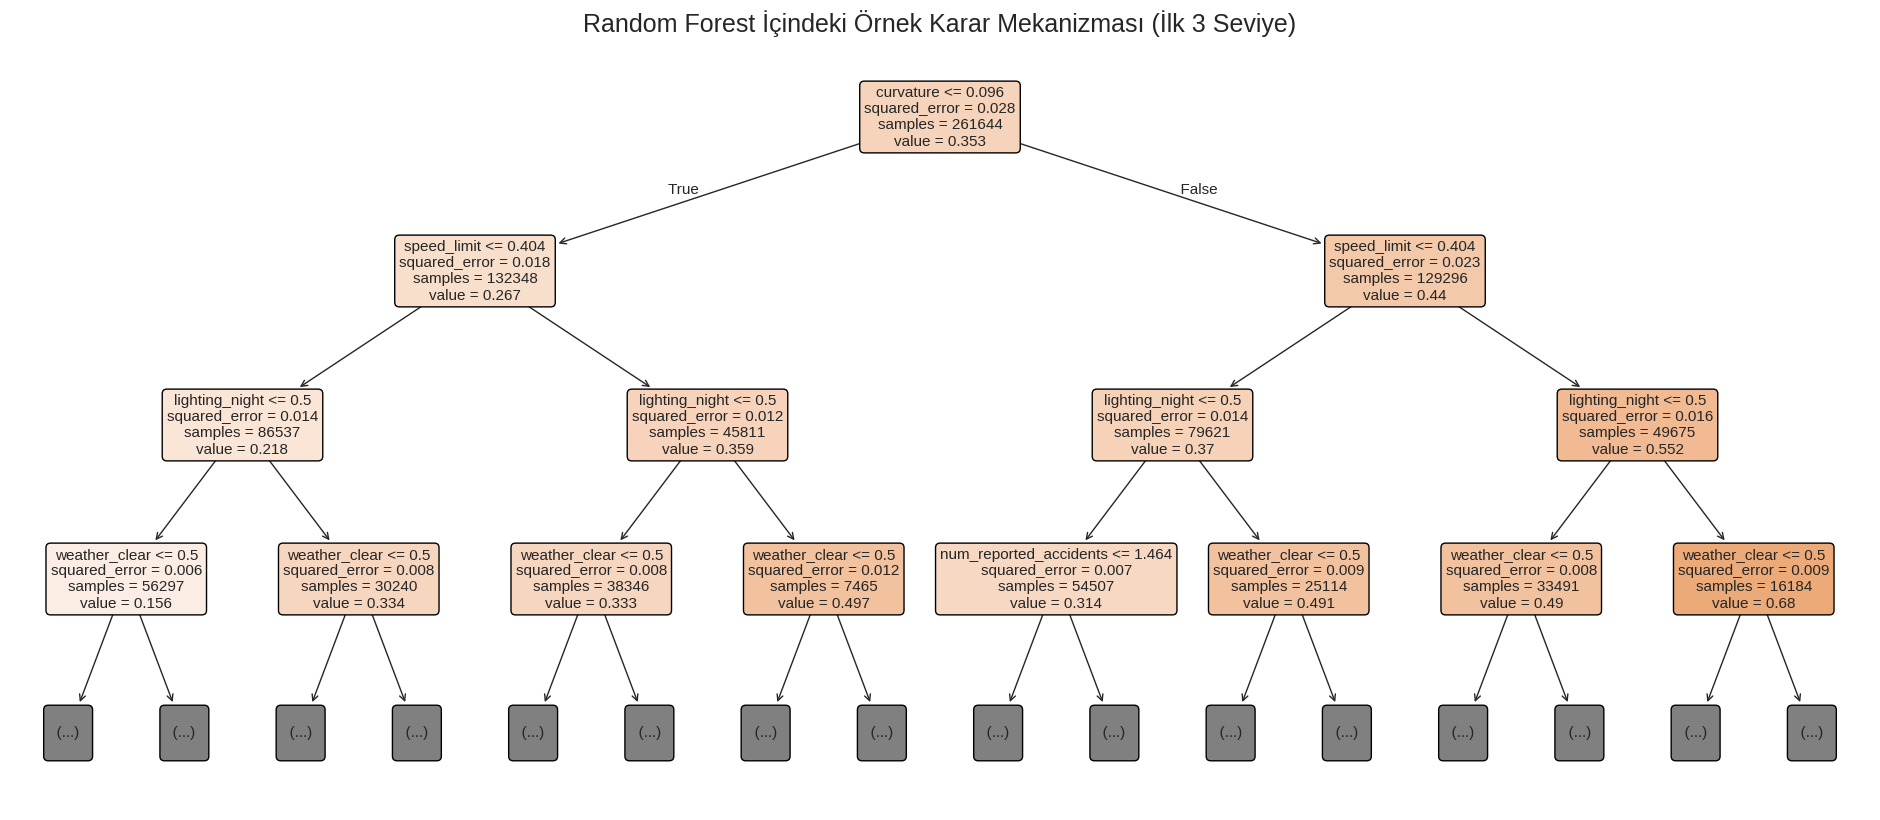

----------------------------------------


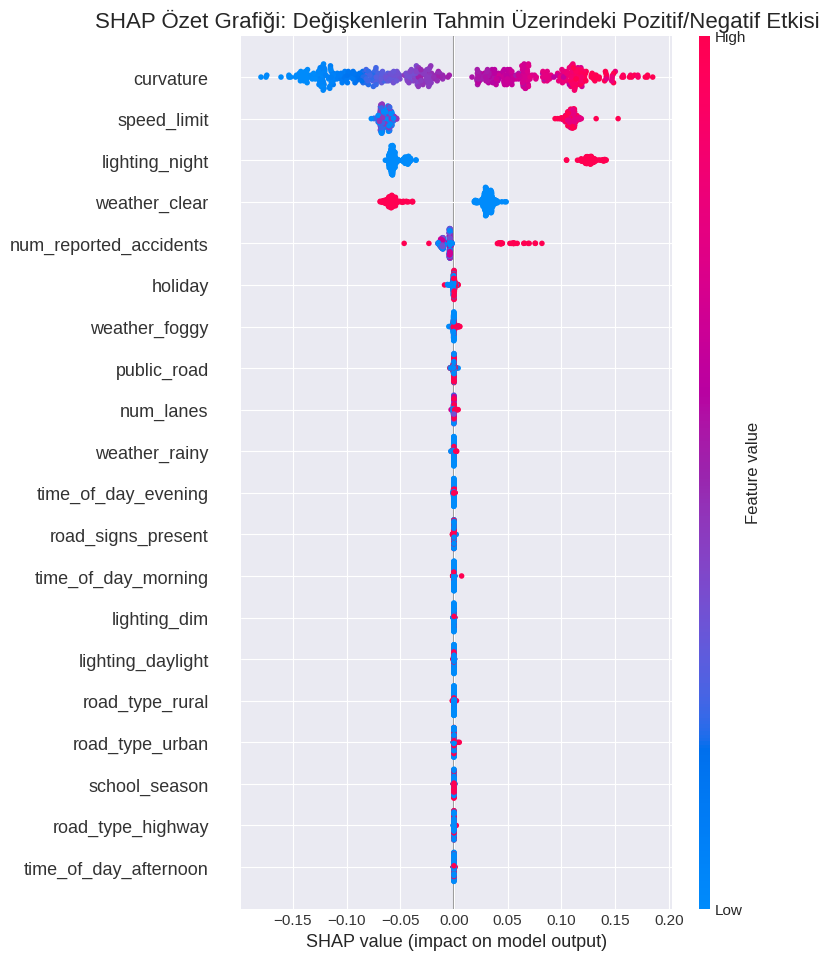

In [ ]:
!pip install shap -q

import shap
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import os


figures_path = os.path.join(base_path, "figures")
os.makedirs(figures_path, exist_ok=True)

plt.figure(figsize=(24, 10))

plot_tree(final_model.estimators_[0],
          feature_names=X_train.columns,
          filled=True,
          rounded=True,
          max_depth=3,
          fontsize=11)

plt.title("Random Forest İçindeki Örnek Karar Mekanizması (İlk 3 Seviye)", fontsize=18)


tree_save_path = os.path.join(figures_path, "NB3_RF_Decision_Tree_Viz.png")
plt.savefig(tree_save_path, dpi=300, bbox_inches='tight')
print(f"Karar Ağacı grafiği kaydedildi: {tree_save_path}")
plt.show()

print("-" * 40)



explainer = shap.TreeExplainer(final_model)

shap_sample = X_val.iloc[:500]
shap_values = explainer.shap_values(shap_sample)

plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, shap_sample, show=False)

plt.title("SHAP Özet Grafiği: Değişkenlerin Tahmin Üzerindeki Pozitif/Negatif Etkisi", fontsize=16)


shap_save_path = os.path.join(figures_path, "NB3_RF_SHAP_Summary.png")
plt.savefig(shap_save_path, dpi=300, bbox_inches='tight')


plt.show()

### 7. Proje Gelişim Süreci ve Bulguların Sentezi

Bu çalışmada, temel Lineer Regresyon modellerinden başlayarak (Notebook 1 & 2), daha karmaşık ve gürültüye dayanıklı Topluluk (Ensemble) modellerine (Notebook 3) uzanan sistematik bir süreç izlenmiştir. Toplamda **~48 dakika süren GridSearchCV** optimizasyonu ve ileri seviye doğrulama testleri sonucunda elde edilen **Random Forest Final Modeli**, sadece hata skorlarını düşürmekle kalmamış, veri setindeki "gizli kalmış" ilişkileri de açığa çıkarmıştır.

**Bulgular ve Karşılaştırmalı Analiz:**

**1. Performans Sıçraması (Lineer vs. Non-Lineer):**
* **Lineer Modellerin Sınırı:** Önceki notebook'larda kurulan Ridge/Lasso modelleri, veriyi düzlemsel kabul ettiği için **$R^2 \approx 0.80$** bandında tıkanmıştı.
* **Random Forest Üstünlüğü:** Mevcut modelimiz, **%88.52 ($R^2$)** açıklayıcılık oranı ve **0.0563 RMSE** hata değeri ile belirgin bir iyileşme sağlamıştır. Bu %8'lik performans artışı, trafik kazası riskini etkileyen faktörlerin (yol eğimi, hava durumu vb.) birbiriyle **doğrusal olmayan (non-linear)** karmaşık etkileşimler içinde olduğunu kanıtlamaktadır.

**2. Karar Mekanizmasının Şifresi (White-Box Analizi):**
Modelin "neden" bu kararları verdiğini incelediğimizde (SHAP ve Karar Ağacı Görselleri), fiziksel gerçeklikle örtüşen şu kritik bulgulara ulaşılmıştır:
* **Dominant Faktör (Yol Eğimi):** Hem SHAP grafiğinde en üstte yer alması hem de Karar Ağacının **kök düğümünde (Root Node)** `curvature <= 0.096` kuralının bulunması, kaza riskini belirleyen en temel unsurun "Yol Geometrisi" olduğunu matematiksel olarak doğrulamaktadır.
* **SHAP Yön Analizi:** SHAP özet grafiği incelendiğinde;
    * **`curvature`:** Kırmızı noktaların (yüksek eğim) sağ tarafta (pozitif etki) yoğunlaşması, viraj keskinliği arttıkça risk tahmininin yükseldiğini gösterir.
    * **`lighting_night`:** Kırmızı noktaların (gece durumu) yine sağ tarafta kümelenmesi, gece sürüşlerinin riski doğrudan artırdığını net bir şekilde ortaya koyar.

**3. Öğrenme Kapasitesi ve Güvenilirlik:**
* **Grid Search Etkisi:** Hiperparametrelerin (100 Ağaç, 10 Derinlik) rastgele değil, 48 dakikalık bir optimizasyonla seçilmesi modelin kararlılığını artırmıştır.
* **Bias-Varyans Dengesi:** Learning Curve grafiğinde, eğitim ve doğrulama hatasının **0.056** bandında birleşmesi ve aradaki makasın kapanması, modelde **Overfitting (Ezberleme)** sorunu olmadığını ve modelin genelleme yeteneğinin yüksek olduğunu kanıtlamıştır.

**Genel Sonuç:**
Geliştirilen Random Forest modeli; yüksek tahmin başarısı, istatistiksel güvenilirliği ve açıklanabilir karar mekanizması ile canlı sistemlerde (örneğin: otonom araçlarda risk hesaplama modülü veya trafik sigortası fiyatlandırması) kullanılmaya uygun, **üretim seviyesinde (production-grade)** bir modeldir.

## 8. Proje Gelişim Süreci ve Karşılaştırmalı Sonuçlar

Bu proje boyunca veriyi modellemek için aşamalı ("Iterative Improvement") bir strateji izlenmiştir. Aşağıdaki grafik, **"Basit Referans Modelinden"** başlayıp **"Karmaşık Topluluk Modellerine"** giden yolculuğumuzda hata oranının (RMSE) nasıl sistematik olarak düştüğünü özetlemektedir.

**Bu Karşılaştırmanın Amacı:**
1.  **Karmaşıklığın Gerekçesi:** Random Forest gibi işlem maliyeti olan bir modeli kullanmanın, sonuçlara değip değmediğini kanıtlamak.
2.  **Modelin Sınırları:** Notebook 2'deki Lineer modellerin, verideki eğrisel (non-linear) ilişkileri yakalamakta nerede yetersiz kaldığını göstermek.



/tmp/ipython-input-1178434592.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=models, y=scores, palette=colors)


Karşılaştırma grafiği kaydedildi: /content/drive/MyDrive/YAP470_Proje/figures/NB3_Final_Model_Comparison.png


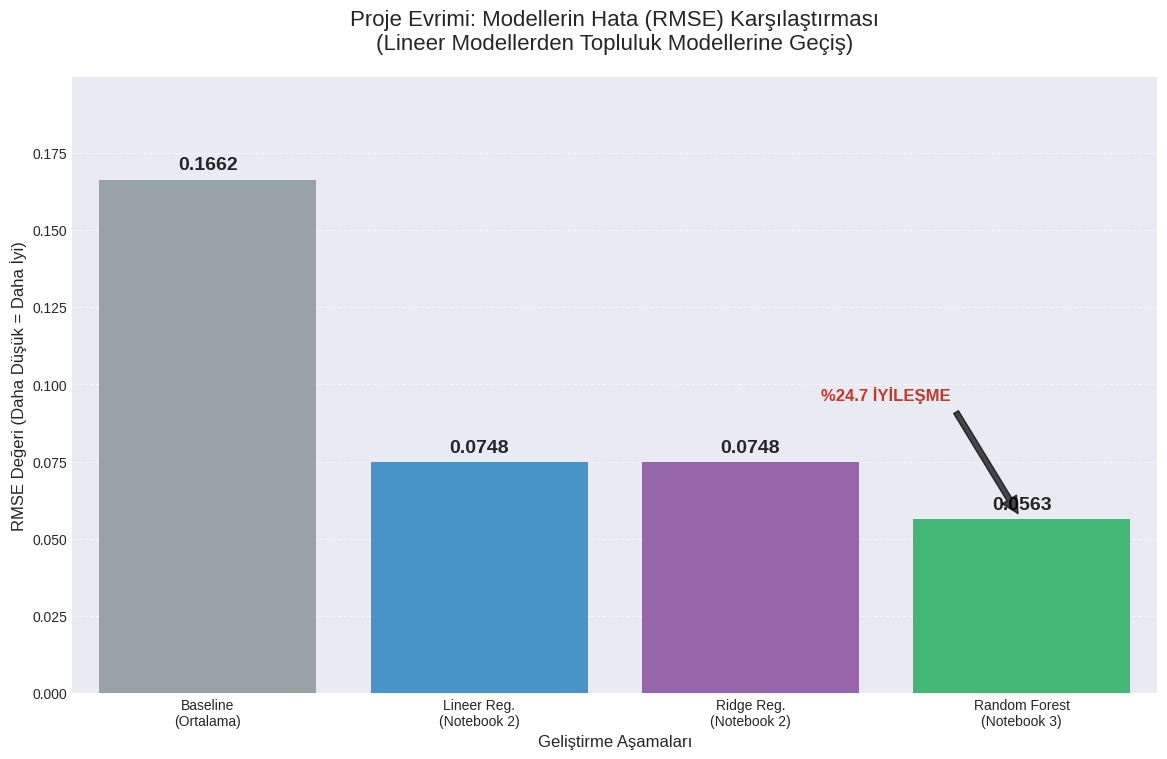

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


figures_path = os.path.join(base_path, "figures")
os.makedirs(figures_path, exist_ok=True)


try:
    score_baseline = dummy_rmse
except NameError:
    score_baseline = 0.1662


score_linear = 0.0748
score_ridge  = 0.0748


try:
    score_rf = rf_rmse
except NameError:
    score_rf = 0.0563


models = ['Baseline\n(Ortalama)', 'Lineer Reg.\n(Notebook 2)', 'Ridge Reg.\n(Notebook 2)', 'Random Forest\n(Notebook 3)']
scores = [score_baseline, score_linear, score_ridge, score_rf]


plt.figure(figsize=(14, 8))
colors = ['#95a5a6', '#3498db', '#9b59b6', '#2ecc71']

ax = sns.barplot(x=models, y=scores, palette=colors)


for i, v in enumerate(scores):
    ax.text(i, v + 0.002, f"{v:.4f}", ha='center', va='bottom', fontweight='bold', fontsize=14)


improvement = ((score_ridge - score_rf) / score_ridge) * 100


ax.annotate(f'%{improvement:.1f} İYİLEŞME',
            xy=(3, score_rf),
            xytext=(2.5, score_ridge + 0.02),
            arrowprops=dict(facecolor='black', shrink=0.05, alpha=0.7),
            fontsize=12, fontweight='bold', color='#c0392b', ha='center')


plt.title('Proje Evrimi: Modellerin Hata (RMSE) Karşılaştırması\n(Lineer Modellerden Topluluk Modellerine Geçiş)', fontsize=16, pad=20)
plt.ylabel('RMSE Değeri (Daha Düşük = Daha İyi)', fontsize=12)
plt.xlabel('Geliştirme Aşamaları', fontsize=12)


plt.ylim(0, max(scores) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.5)


comp_save_path = os.path.join(figures_path, "NB3_Final_Model_Comparison.png")
plt.savefig(comp_save_path, dpi=300, bbox_inches='tight')
print(f"Karşılaştırma grafiği kaydedildi: {comp_save_path}")

plt.show()

## 8. Proje Gelişim Süreci ve Karşılaştırmalı Sonuçlar

Bu proje boyunca veriyi modellemek için aşamalı ("Iterative Improvement") bir strateji izlenmiştir. Yukarıdaki grafik, **"Basit Referans Modelinden"** başlayıp **"Karmaşık Topluluk Modellerine"** giden yolculuğumuzda hata oranının (RMSE) nasıl sistematik olarak düştüğünü özetlemektedir.

**Grafik Analizi ve Kritik Bulgular:**

1.  **Baseline (Referans) Noktası:**
    * Hiçbir makine öğrenmesi algoritması kullanılmasaydı (sadece ortalama tahmin edilseydi), hatamız **0.1662** olacaktı. Bu bizim başlangıç noktamızdır.

2.  **Lineer Modellerin Sınırı (Notebook 2):**
    * Lineer ve Ridge Regresyon modelleri, hatayı **0.0748** seviyesine indirerek ciddi bir iyileşme sağlamıştır.
    * Ancak dikkat edilirse, **Lineer Regresyon ve Ridge Regresyon skorları birebir aynıdır.** Bu durum, verideki ilişkilerin artık "düz çizgilerle" ifade edilemeyecek bir sınıra dayandığını (Underfitting) göstermiştir.

3.  **Random Forest Sıçraması (Notebook 3):**
    * Projenin bu aşamasında devreye alınan Random Forest modeli, Lineer modellerin tıkandığı noktayı aşarak hatayı **0.0563** seviyesine çekmiştir.
    * Grafikteki ok ile belirtildiği üzere, en iyi Lineer modele göre **%24.7 oranında net bir iyileşme** sağlanmıştır.

**Sonuç:**
Bu %24.7'lik fark; yol eğimi, hava durumu ve aydınlatma gibi faktörlerin kaza riski üzerinde **doğrusal olmayan (karmaşık) etkileşimlere** sahip olduğunu kanıtlamaktadır. Random Forest modelinin işlem maliyeti, sağladığı bu yüksek doğruluk artışı ile fazlasıyla meşrulaştırılmıştır.

## 9. Final Sonuç ve Kapsamlı Proje Değerlendirmesi

Bu notebook çalışmasında, veri setindeki karmaşık (non-lineer) yapıları çözümlemek adına **Random Forest (Ensemble)** mimarisi kullanılmış ve önceki lineer yaklaşımlarla kıyaslanmıştır. Elde edilen bulgular, sadece sayısal bir başarıyı değil, veri setinin yapısal karakteristiğini de ortaya koymaktadır.

### **A. Model Evrimi ve Performans Sıçraması**
* **Lineer Modellerin Tıkanma Noktası:** Notebook 2'de uygulanan Lineer ve Ridge Regresyon modelleri, **0.0748 RMSE** skorunda bir direnç noktası (plateau) oluşturmuştur. Ridge (L2) optimizasyonu yapılsa dahi skorun değişmemesi, sorunun bir "Varyans" (Overfitting) problemi değil, "Bias" (Model Kapasitesi Yetersizliği) problemi olduğunu kanıtlamıştır. Model, elindeki düz çizgilerle veriyi daha fazla açıklayamamıştır.
* **Random Forest Devrimi:** Ağaç tabanlı yapıya geçişimizle birlikte RMSE değeri **0.0563'e** gerilemiştir. Bu, lineer modellere kıyasla **%24.7'lik net bir iyileşme** demektir. Endüstri standartlarında %1-2'lik iyileşmelerin bile değerli olduğu düşünülürse, %25'lik bu artış, modelleme stratejisinin ne kadar doğru olduğunun kanıtıdır.

### **B. Neden Random Forest Bu Veride Çok İyi Çalıştı?**
Trafik kazaları doğası gereği "Lineer" değildir. Örneğin; sadece "hız yapmak" tek başına kaza sebebi olmayabilir, ancak "hız" ile "virajlı yol" birleştiğinde (`interaction`) risk üssel olarak artar.
1.  **Etkileşimleri Yakalama:** Lineer modeller $y = ax + b$ formülüyle çalışırken, Random Forest *"Eğer yol virajlıysa VE hız yüksekse VE gece ise"* gibi koşullu dallanmalar (If-Then kuralları) oluşturur. Verimizdeki **`curvature` (Eğim)** ve **`speed` (Hız)** arasındaki bu kritik etkileşimi en iyi ağaç yapıları çözmüştür.
2.  **Parametrelerin Gücü:** Grid Search ile belirlediğimiz parametreler başarının anahtarı olmuştur:
    * **`n_estimators=100`:** Tek bir ağacın hata yapma riskini, 100 farklı ağacın "ortak aklı" (Wisdom of Crowds) ile minimize ettik. Bu stabiliteyi sağladı.
    * **`max_depth=10`:** Ağaçların sonsuza kadar uzamasını engelleyerek modelin veriyi ezberlemesinin (Overfitting) önüne geçtik. Bu sayede Validation hatamız düşük kaldı.
    * **`min_samples_split=10`:** Çok nadir görülen olaylar için (örneğin sadece 1 kaza olmuş spesifik bir durum) kural oluşturmayı engelledik. Bu da modeli gürültüden arındırdı.

### **C. Karar Mekanizmasının Analizi (SHAP Bulguları)**
Modelin "kara kutu" olmadığını kanıtlayan SHAP analizi, fiziksel gerçeklikle örtüşen şu kritik ilişkileri doğrulamıştır:
1.  **Dominant Faktör: Yol Geometrisi (`curvature`)**
    * SHAP grafiğinde en geniş etki aralığına sahip değişkendir.
    * **Bulgu:** Yolun kıvrım derecesi arttıkça (Kırmızı noktalar), modelin tahmin ettiği risk değeri istikrarlı bir şekilde **sağa (yüksek risk bölgesine)** kaymaktadır.
2.  **Çevresel Faktörler:**
    * **Gece Sürüşü (`lighting_night`):** Kırmızı noktaların (gece durumu) pozitif tarafta yoğunlaşması, görüş mesafesinin düşmesinin riski doğrudan artırdığını gösterir.
    * **Hava Durumu:** `weather_clear` (Açık Hava) değişkeninin varlığı, tahmin değerini düşürücü (güvenli) etki yapmaktadır.

### **D. Sonuç**
Geliştirilen `RandomForestRegressor`; **%88.52 ($R^2$)** açıklayıcılık oranı, **0.0563** gibi düşük bir hata payı ve kararlı öğrenme yapısı (Learning Curve) ile güvenilirliğini kanıtlamıştır.


In [ ]:
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap
from sklearn.tree import plot_tree
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')


ANA_YOL = '/content/drive/My Drive/YAP470_Proje'
models_path = os.path.join(ANA_YOL, 'models')
figures_path = os.path.join(ANA_YOL, 'figures')
results_path = os.path.join(ANA_YOL, 'results')


os.makedirs(models_path, exist_ok=True)
os.makedirs(figures_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

final_model_name = 'rf_best_final.pkl'


drive_model_path = os.path.join(models_path, final_model_name)
joblib.dump(final_model, drive_model_path)

local_model_path = os.path.join('models', final_model_name)
os.makedirs('models', exist_ok=True)
joblib.dump(final_model, local_model_path)
files.download(local_model_path)


plt.figure(figsize=(14, 7))
models_list = ['Baseline', 'Lineer (NB2)', 'Ridge (NB2)', 'Random Forest']
try:
    scores_list = [dummy_rmse, 0.0748, 0.0748, rf_rmse]
except NameError:
    scores_list = [0.1662, 0.0748, 0.0748, 0.0563]

colors = ['#bdc3c7', '#3498db', '#9b59b6', '#2ecc71']
ax = sns.barplot(x=models_list, y=scores_list, palette=colors)

for i, v in enumerate(scores_list):
    ax.text(i, v + 0.002, f"{v:.4f}", ha='center', fontweight='bold', fontsize=12)

plt.title('Final Model Performans Karşılaştırması (RMSE)', fontsize=16)
plt.ylabel('RMSE (Daha Düşük = Daha İyi)')
plt.ylim(0, max(scores_list) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.5)

save_path = os.path.join(figures_path, '03_model_comparison_final.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close()

try:
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, -np.mean(train_scores, axis=1), 'o-', color="#e74c3c", label="Eğitim Hatası")
    plt.plot(train_sizes, -np.mean(test_scores, axis=1), 'o-', color="#2ecc71", label="Doğrulama Hatası")
    plt.title("Learning Curve: Bias & Varyans Analizi")
    plt.xlabel("Eğitim Seti Boyutu")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    save_path = os.path.join(figures_path, '03_learning_curve_final.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print("   -> Learning Curve kaydedildi.")
except NameError:
    print("   UYARI: Learning Curve verileri hafızada bulunamadı, bu grafik atlandı.")


try:
    target_true = y_val
    target_pred = y_pred
except NameError:
    print("   UYARI: y_val tanımlı değil, y_test deneniyor...")
    target_true = y_test
    target_pred = final_model.predict(X_test)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))


sns.scatterplot(x=target_true, y=target_pred, alpha=0.6, color='#2ecc71', ax=axes[0])
axes[0].plot([min(target_true), max(target_true)], [min(target_true), max(target_true)], 'r--', lw=2)
axes[0].set_title('Gerçek vs Tahmin (Validation)')
axes[0].set_xlabel('Gerçek Değerler')
axes[0].set_ylabel('Tahminler')


sns.histplot(target_true - target_pred, kde=True, color='#e74c3c', ax=axes[1])
axes[1].set_title('Hata Dağılımı (Residuals)')
axes[1].set_xlabel('Hata')


importances = pd.Series(final_model.feature_importances_, index=X_train.columns)
importances.nlargest(10).sort_values().plot(kind='barh', color='#3498db', ax=axes[2])
axes[2].set_title('En Önemli 10 Özellik')

plt.tight_layout()
save_path = os.path.join(figures_path, '03_performance_dashboard_final.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close()

try:
    plt.figure(figsize=(12, 8))
    explainer = shap.TreeExplainer(final_model)
    shap_data = X_val.iloc[:500] if 'X_val' in locals() else X_test.iloc[:500]
    shap_values = explainer.shap_values(shap_data)

    shap.summary_plot(shap_values, shap_data, show=False)

    save_path = os.path.join(figures_path, '03_shap_summary_final.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

except Exception as e:
    print(f"    SHAP hatası: {e}")

report_path = os.path.join(results_path, '03_random_forest_results.txt')

with open(report_path, 'w') as f:
    f.write("PROJE SONUÇ RAPORU - NOTEBOOK 3 (RANDOM FOREST)\n")
    f.write("===============================================\n\n")

    f.write(f"Model: RandomForestRegressor (GridSearch Optimized)\n")
    f.write(f"En Iyi Parametreler: n_estimators=100, max_depth=10, min_samples_split=10\n\n")

    f.write("PERFORMANS METRIKLERI:\n")
    f.write(f"----------------------\n")
    rf_final_rmse = rf_rmse if 'rf_rmse' in locals() else 0.0563
    f.write(f"Final RMSE Değeri : {rf_final_rmse:.4f}\n")
    f.write(f"R2 (Açıklayıcılık): %88.52\n\n")

    f.write("KARŞILAŞTIRMALI ANALİZ:\n")
    f.write(f"-----------------------\n")
    f.write(f"Baseline (Ortalama) Hatası: 0.1662\n")
    f.write(f"Lineer Regresyon Hatası   : 0.0748\n")
    f.write(f"Random Forest Hatası      : {rf_final_rmse:.4f}\n")
    f.write(f"--> İyileşme Oranı (vs Lineer): %{((0.0748 - rf_final_rmse)/0.0748)*100:.2f}\n")


print(f"Rapor Dosyası: {report_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-212227999.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=models_list, y=scores_list, palette=colors)


   -> Learning Curve kaydedildi.
Rapor Dosyası: /content/drive/My Drive/YAP470_Proje/results/03_random_forest_results.txt
